# functiong說明

save_and_open_excel 存成EXCEL 然後 打開
>save_and_open_excel(dataframe, file_name="模型相關數值.xlsx")

analyze_nan_and_zero_values 檢視空值
>analyze_nan_and_zero_values(data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False)

output_coefficients 輸出模型係數
>output_coefficients(model, poly_features, feature_names)

In [1]:
def save_and_open_excel(dataframe, file_name="模型相關數值.xlsx"):
    """
    將給定的 dataframe 保存到指定的 Excel 工作表中，如果工作表已存在則覆蓋，
    並嘗試在支持的應用程式中打開該 Excel 文件。

    :param dataframe: 要保存的 pandas DataFrame。
    :param file_name: Excel 文件的名稱，默認為 'vif_data.xlsx'。
    """
    import pandas as pd
    import os

    # 獲取 dataframe 的變數名稱
    frame_name = [name for name, var in globals().items() if var is dataframe][0]

    # 檢查工作表是否存在，如果不存在則創建
    if not os.path.isfile(file_name):
        with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)
    else:
        # 工作表存在，加載工作簿
        with pd.ExcelWriter(
            file_name, engine="openpyxl", mode="a", if_sheet_exists="replace"
        ) as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)

    # 嘗試打開創建的 Excel 文件
    try:
        os.startfile(file_name)
    except AttributeError:
        # 如果 os.startfile() 不可用（例如在非 Windows 系統上），使用適當的替代方案
        if os.name == "posix":
            os.system(f'open "{file_name}"')
        else:
            os.system(f'start "{file_name}"')
    except Exception as e:
        print(f"打開 Excel 文件時發生錯誤: {e}")

In [2]:
"""檢視空值及零值"""

import pandas as pd


def analyze_nan_and_zero_values(
    data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False
):
    """
    檢查0值和 nan 的數量
    threshold 為 百分比，例threshold=20，會回傳 零值+NAN佔比 (%) 大於20% 的
    當 threshold = 0 會回傳全部
    """

    # 如果輸入是文件路徑，讀取CSV文件並轉換成Pandas DataFrame

    if isinstance(data, str):

        file_source_pd = pd.read_csv(data)

    # 如果輸入是Pandas DataFrame，直接使用它

    elif isinstance(data, pd.DataFrame):

        file_source_pd = data

    else:

        raise ValueError(
            "Invalid input type. Input must be either file path or Pandas DataFrame."
        )

    # 計算這個範圍內每一欄的空白值(NaN)數量

    nan_values_per_column_in_range = file_source_pd.isnull().sum(axis=0)

    # 計算每個欄位的總數據量

    total_data_per_column = len(file_source_pd)

    # 計算每個欄位的空白值(NaN)佔比

    nan_percentage_per_column = (
        nan_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算這個範圍內每一欄的零值數量

    zero_values_per_column_in_range = (file_source_pd == 0).sum(axis=0)

    # 計算每個欄位的零值佔比

    zero_percentage_per_column = (
        zero_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算每個欄位的零值和NaN值的總數

    total_zero_and_nan_per_column = (
        zero_values_per_column_in_range + nan_values_per_column_in_range
    )

    # 計算每個欄位的零值和NaN值總數的佔比

    total_zero_and_nan_percentage_per_column = (
        total_zero_and_nan_per_column / total_data_per_column
    ) * 100

    # 將結果轉換為 DataFrame

    values_df = pd.DataFrame(
        {
            "欄位名稱": nan_values_per_column_in_range.index,
            "零值+NAN佔比 (%)": total_zero_and_nan_percentage_per_column.values.round(
                2
            ),
            "空白值(NaN)數量": nan_values_per_column_in_range.values,
            "空白值(NaN)佔比 (%)": nan_percentage_per_column.values.round(2),
            "零值數量": zero_values_per_column_in_range.values,
            "零值佔比 (%)": zero_percentage_per_column.values.round(2),
        }
    )

    # 將 DataFrame 存儲到 CSV 檔案中
    values_df.to_csv("零值與空白值統計.csv", index=False, encoding="utf-8-sig")

    # 如果 threshold 等於 0，則返回所有欄位
    if threshold == 0:
        return values_df

    # 篩選出 '零值+NAN佔比 (%)' 大於指定閾值的欄位

    filtered_values_df = values_df[values_df["零值+NAN佔比 (%)"] > threshold]

    # 根據指定的列進行排序

    sorted_values_df = filtered_values_df.sort_values(
        by=sort_column, ascending=ascending
    )

    return sorted_values_df


# 測試


# result_df = analyze_nan_and_zero_values(clean_data, threshold=0, sort_column='欄位名稱', ascending=False)


# print(result_df)

In [3]:
"""輸出模型係數"""

import pandas as pd
import os


def output_coefficients(model, poly_features, feature_names):
    """
    model：你的模型物件，通常是訓練好的機器學習模型，例如線性回歸模型、支持向量機模型等。

    poly_features：多項式特徵物件，這通常是一個 PolynomialFeatures 物件，用於產生多項式特徵。

    feature_names：特徵名稱列表，這是一個包含特徵名稱的字串列表，用於識別每個特徵
    """
    coef = model.coef_
    intercept = model.intercept_

    # 創建包含係數和特徵名稱的DataFrame
    coef_data = {
        "係數": [coef[i] for i in range(len(coef)) if coef[i] != 0],
        "特徵": [feature_names[i] for i in range(len(coef)) if coef[i] != 0],
    }
    coef_df = pd.DataFrame(coef_data)
    coef_df = pd.concat(
        [pd.DataFrame({"係數": [intercept], "特徵": ["截距"]}), coef_df],
        ignore_index=True,
    )

    # 創建包含特徵名稱的DataFrame
    feature_names_df = pd.DataFrame({"特徵名稱": feature_names})

    # 輸出表格
    print("係數和截距表：")
    print(coef_df)
    print("\n特徵名稱表：")
    print(feature_names_df)

    # 將 DataFrame 存入 Excel
    coef_df.to_excel("coefficients.xlsx", index=False)

    # 使用 os 模組打開 Excel 檔案
    os.system("start coefficients.xlsx")

In [4]:
"""創建混合矩陣"""

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # 確保導入 numpy


def plot_confusion_matrix(y_true, y_pred, figsize=(10, 7), cmap="Blues"):
    """
    繪製混淆矩陣的熱力圖。

    參數:
    y_true -- 真實標籤
    y_pred -- 預測標籤
    figsize -- 圖形的大小 (預設為 (10, 7))
    cmap -- 熱力圖的顏色映射 (預設為 'Blues')
    """
    # 生成混淆矩陣
    cm = confusion_matrix(y_true, y_pred)

    # 轉換為比例
    cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # 使用 Seaborn 畫出混淆矩陣的熱力圖
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm_ratio, annot=True, fmt=".2f", cmap=cmap
    )  # fmt='.2f' 指定顯示兩位小數
    plt.title("Confusion Matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()


# 使用此函數的示例
# plot_confusion_matrix(y_test, y_pred_lr)  # 調用函數繪製混淆矩陣

# 輸入資料

In [5]:
import pandas as pd

file_path = r"../飲料店總表0307final01_補上人氣_補值_hg.xlsx"

# dataset = pd.read_csv(file_path, sep=",", encoding="UTF-8")

dataset = pd.read_excel(file_path)
# print(dataset.info())


In [ ]:
dataset.describe().round(2)

In [ ]:
analyze_nan_and_zero_values(dataset, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

## 選擇需要的資料

In [14]:
"""selected_data
"""

selected_data = dataset[
    [
        "star",
        "school_counts",
        "drink_counts",
        "train_counts",
        "youbike_counts",
        "bus_counts",
        "park_counts",
        "night_market_counts",
        "sports_facilities_counts",
        "mrt_counts",
        "movie_theater_counts",
        "hospital_counts",
        "salary_income_median",
        "people_flow_mean",
        "knock_down_price_mean",
        "weekend_open",
        "road_area_ratio",
        "age",
        "weekday_working_hours_average",
        # "comment",
        # "people_flow_average",
        "popularity",
        # "KMEANS",
    ]
]

# selected_data

## 刪掉關係性太低的


In [7]:
"""篩選關係姓小的"""

# 計算與 'KMEANS' 欄位相關性的系列
corr_with_kmeans = selected_data.corr()["popularity"]

# 篩選出與 'KMEANS' 相關性小於0.1的欄位
low_corr_with_kmeans = corr_with_kmeans[abs(corr_with_kmeans) < 0.1]

# 列出這些欄位的名稱
print("與 'popularity' 欄位相關性小於0.1的欄位：")
print(low_corr_with_kmeans.index.tolist())
selected_data = selected_data.drop(low_corr_with_kmeans.index.tolist(), axis=1)

與 'popularity' 欄位相關性小於0.1的欄位：
['star', 'train_counts', 'night_market_counts', 'people_flow_mean', 'knock_down_price_mean', 'weekday_working_hours_average']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設的 selected_data 和 'popularity' 欄位數據
np.random.seed(0)

# 使用 pd.qcut 進行分類
Y_classification_pd = pd.DataFrame({"value": selected_data["popularity"]})
Y_classification_pd["category"] = pd.qcut(
    Y_classification_pd["value"],
    q=5,
    labels=["Category 0", "Category 1", "Category 2", "Category 3", "Category 4"],
)

# 分組並獲得統計信息
summary_df = (
    Y_classification_pd.groupby("category")["value"]
    .agg([("最小值", "min"), ("最大值", "max"), ("數量", "size")])
    .reset_index()
)

# 建立分類
value_category_ranges = [
    summary_df.loc[0, "最小值"],  # 第一類別的最小值
    summary_df.loc[1, "最小值"],  # 第二類別的最小值
    summary_df.loc[2, "最小值"],  # 第三類別的最小值
    summary_df.loc[3, "最小值"],  # 第四類別的最小值
    summary_df.loc[4, "最小值"],  # 第五類別的最小值
    summary_df.loc[4, "最大值"],  # 第五類別的最大值
]

# 使用 pd.cut 根據新的範圍劃分 'popularity' 欄位
selected_data["popularity_category"] = pd.cut(
    selected_data["popularity"],
    bins=value_category_ranges,
    right=False,  # 包括左邊界，排除右邊界
    labels=[0, 1, 2, 3, 4],
)

# 將超出範圍的值填充為最大範圍的類別（4）
selected_data["popularity_category"].fillna(4, inplace=True)

# 將 'popularity_category' 列轉換為整數類型
selected_data["popularity_category"] = selected_data["popularity_category"].astype(int)

# 打印新的分類結果和每類的數量
print(selected_data["popularity_category"].value_counts().sort_index())
print(summary_df)

In [15]:
"""因為數值分布差很多 刪掉極端"""

# 直接在原始 DataFrame 中刪除 'popularity' 小於 8726.779 的行
selected_data = selected_data[selected_data["popularity"] <= 2213.641425]
selected_data = selected_data[selected_data["popularity"] != 0]

# '''資料分布不均 取log'''
selected_data["popularity"] = np.log10(selected_data["popularity"])

# 顯示過濾後的數據
# print(selected_data)

In [19]:
# 使用 pd.cut 根據數值大小劃分 'popularity' 欄位
# 計算數據範圍
min_val = selected_data['popularity'].min()
max_val = selected_data['popularity'].max()

# 創建五個分組的邊界值
bins = np.linspace(min_val, max_val, 6)

# 使用 pd.cut 來分組
selected_data['popularity_category'] = pd.cut(
    selected_data['popularity'],
    bins=bins,
    include_lowest=True,  # 確保包括最低值
    labels=[0, 1, 2, 3, 4]  # 這是每個範圍的標籤
)

# 打印新的分類結果和每類的數量
# print(selected_data['popularity_category'].value_counts().sort_index())

# 建立統計信息表格
summary_df = selected_data.groupby('popularity_category')['popularity'].agg(
    最小值='min',
    最大值='max',
    數量='size'
).reset_index()
print(summary_df)


  popularity_category       最小值       最大值    數量
0                   0 -3.007767 -1.737892    85
1                   1 -1.735366 -0.467482   265
2                   2 -0.453712  0.799761   555
3                   3  0.806709  2.072348   954
4                   4  2.073407  3.343662  2352


In [20]:
"""轉位數"""

selected_data["age"] = selected_data["age"].round(2)
selected_data["road_area_ratio"] = selected_data["road_area_ratio"].round(3)

# dataset['brand'] = dataset['brand'].fillna(-1)
# dataset['Saturday_open_hours'] = dataset['Saturday_open_hours'].fillna(-1)
# dataset['Sunday_open_hours'] = dataset['Sunday_open_hours'].fillna(-1)

# X = dataset.drop(
#     ['comment','star','people_flow_average','popularity',"KMEANS"], axis=1
# )
y = selected_data["popularity_category"]
X = selected_data.drop(["popularity", "popularity_category"], axis=1)

# y = dataset["KMEANS"]
# y = y.to_frame()
# print(type(y))

### 輸入前最後一次確認參數型態

In [ ]:
# analyze_nan_and_zero_values(X, 0, sort_column="零值+NAN佔比 (%)", ascending=False)
analyze_nan_and_zero_values(y, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

In [22]:
# 分割訓練和測試
from sklearn.model_selection import train_test_split

# test_size 切的尺寸 30% random_state讓抽取可以是穩定的結果(第一次抽根第十次抽是一樣的)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25
)

In [ ]:
print(type(X_train))

# 模型

In [23]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.metrics import accuracy_score, classification_report

## Bayesion classifier (貝式分類器)

## 高斯貝式分類器 GaussianNB

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# 訓練貝葉斯分類器
Bayesion_classifier_model = GaussianNB()
Bayesion_classifier_model.fit(X_train, y_train)

# 預測測試集
y_pred_bc = Bayesion_classifier_model.predict(X_test)

# 計算準確率和顯示分類報告
# print("Accuracy:", accuracy_score(y_test, y_pred))
accuracy_bc = accuracy_score(y_test, y_pred_bc)
classification_report_bc = classification_report(y_test, y_pred_bc)

print(accuracy_bc)
print(classification_report_bc)

0.5213607594936709
              precision    recall  f1-score   support

           0       0.23      0.74      0.35        23
           1       0.25      0.38      0.30        72
           2       0.21      0.29      0.24       165
           3       0.30      0.17      0.22       274
           4       0.75      0.71      0.73       730

    accuracy                           0.52      1264
   macro avg       0.35      0.46      0.37      1264
weighted avg       0.54      0.52      0.52      1264



### 混淆矩陣(Confusion Matrix)

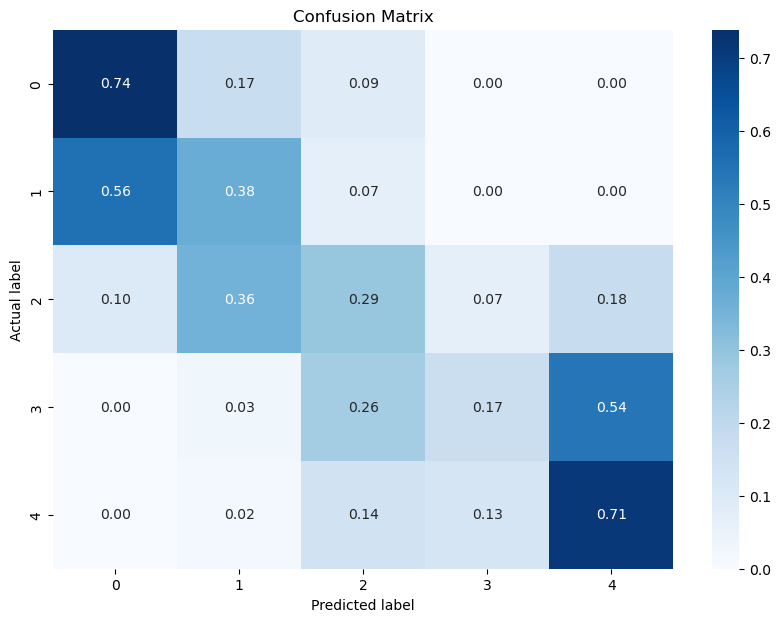

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 使用模型預測測試集
y_pred_bc = Bayesion_classifier_model.predict(X_test)

# 生成混淆矩陣
cm = confusion_matrix(y_test, y_pred_bc)

# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

### 交叉驗證(Cross-Validation)

In [26]:
from sklearn.model_selection import cross_val_score

# 定義模型
bc_model_cv = GaussianNB()

# 進行5-fold交叉驗證
scores = cross_val_score(bc_model_cv, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

每一輪的準確率: [0.51016949 0.53728814 0.54159593 0.4991511  0.50254669]
平均準確率: 0.5181502690570056


### 參數調整(Parameter Tuning)

Best parameters: {'var_smoothing': 0.24770763559917108}
Best cross-validation score: 0.5785577393456303


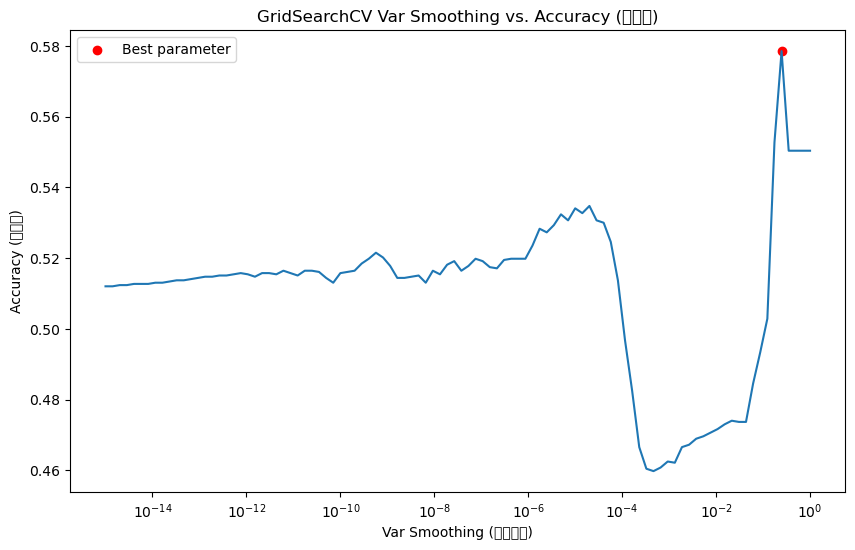

In [27]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# 定义参数范围
param_grid = {
    "var_smoothing": np.logspace(
        0, -15, num=100
    )  # 控制模型對於數據中的噪聲的容忍度，通過向變異數中加入一個小的值來穩定計算過程
}

# 建立 GridSearchCV 對象
grid_search_bc = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=5,
    scoring="accuracy",
)

# 執行網格搜索
grid_search_bc.fit(X_train, y_train)

# 輸出最佳參數和最佳交叉驗證分數
print("Best parameters:", grid_search_bc.best_params_)
print("Best cross-validation score:", grid_search_bc.best_score_)


# 繪製結果
mean_scores = grid_search_bc.cv_results_[
    "mean_test_score"
]  # 獲取每個參數的平均測試分數
smoothing_values = param_grid["var_smoothing"]


plt.figure(figsize=(10, 6))
plt.plot(smoothing_values, mean_scores)
plt.scatter(
    grid_search_bc.best_params_["var_smoothing"],
    grid_search_bc.best_score_,
    color="red",
    marker="o",
    label="Best parameter",
)  # 標記最佳參數
plt.xscale("log")
plt.xlabel("Var Smoothing (對數刻度)")
plt.ylabel("Accuracy (準確率)")
plt.title("GridSearchCV Var Smoothing vs. Accuracy (準確率)")
plt.legend()  # 顯示圖例
plt.show()

In [28]:
import matplotlib.pyplot as plt

# 解決字體問題
plt.rcParams["font.family"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

### 利用最佳參數來做

最佳 GaussianNB 模型的準確度: 0.6115506329113924
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.32      0.90      0.47        72
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       274
           4       0.67      0.97      0.79       730

    accuracy                           0.61      1264
   macro avg       0.20      0.37      0.25      1264
weighted avg       0.40      0.61      0.48      1264



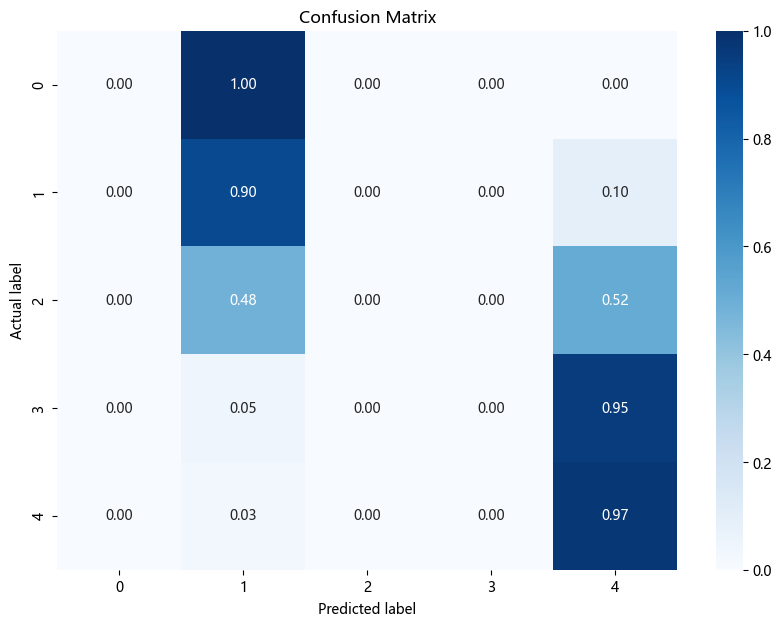

每一輪的準確率: [0.58135593 0.56610169 0.5959253  0.57724958 0.5721562 ]
平均準確率: 0.5785577393456303


['Bayesion_classifier_model_best.joblib']

In [29]:
from sklearn.naive_bayes import GaussianNB

# 使用 GridSearchCV 找到的最佳參數
best_var_smoothing = grid_search_bc.best_params_["var_smoothing"]

# 建立一個新的 GaussianNB 模型，使用最佳的 var_smoothing 參數
Bayesion_classifier_model_best = GaussianNB(var_smoothing=best_var_smoothing)

# 使用訓練數據訓練模型
Bayesion_classifier_model_best.fit(X_train, y_train)

y_pred_bc_best = Bayesion_classifier_model_best.predict(X_test)
# 計算準確率
accuracy_bc_best = accuracy_score(y_test, y_pred_bc_best)

# 生成分類報告
classification_report_bc_best = classification_report(y_test, y_pred_bc_best)

# 打印結果
print("最佳 GaussianNB 模型的準確度:", accuracy_bc_best)
print(classification_report_bc_best)

plot_confusion_matrix(y_test, y_pred_bc_best)


"""交叉驗證(Cross-Validation)"""
# 進行5-fold交叉驗證
scores = cross_val_score(Bayesion_classifier_model_best, X_train, y_train, cv=5)


# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

"""輸出模型"""
from joblib import dump, load

# 保存模型
dump(Bayesion_classifier_model_best, "Bayesion_classifier_model_best.joblib")

### 學習曲線(Learning Curve)

如果訓練分數和交叉驗證分數之間的差距很大，可能表示模型存在過擬合；如果兩者都很低，則可能表示欠擬合。理想情況下，隨著訓練樣本的增加，訓練分數和交叉驗證分數應該逐漸接近，且分數較高。

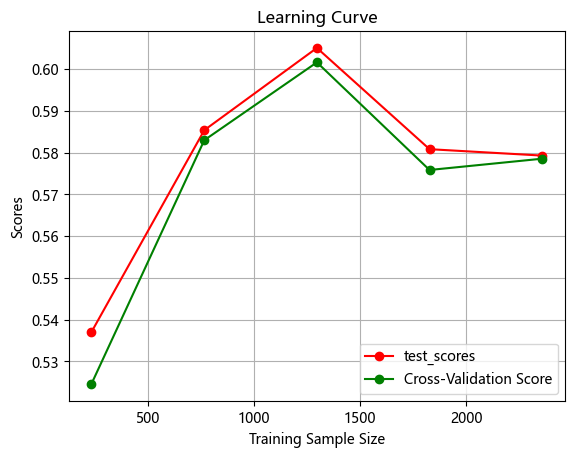

訓練和測試分數的差異百分比0.13%


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits

# 獲取學習曲線數據
train_sizes, train_scores, test_scores = learning_curve(
    Bayesion_classifier_model_best,
    X_train,  # 特徵數據
    y_train,  # 目標數據
    cv=5,  # 交叉驗證分割策略
    # n_jobs=-1,      # 使用所有的 CPU 核心進行計算
    train_sizes=np.linspace(0.1, 1.0, 5),  # 定義了用於生成學習曲線的訓練集大小的比例
)


# 計算平均和標準差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Sample Size")
plt.ylabel("Scores")
plt.grid()

# # 填充訓練和測試分數之間的顏色
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# 計算訓練和測試分數的差異百分比
score_diff_percentage = (
    (train_scores_mean - test_scores_mean) / train_scores_mean
) * 100


# 繪製訓練和測試的分數線
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="test_scores")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()

print(f"訓練和測試分數的差異百分比{score_diff_percentage[-1]:.2f}%")

## 多項式貝氏分類器 MultinomialNB

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# 訓練貝葉斯分類器
MultinomialNB_model = MultinomialNB()
MultinomialNB_model.fit(X_train, y_train)

# 預測測試集
y_pred_mnb = MultinomialNB_model.predict(X_test)

# 計算準確率和顯示分類報告
# print("Accuracy:", accuracy_score(y_test, y_pred))
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
classification_report_mnb = classification_report(y_test, y_pred_mnb)

print(accuracy_mnb)
print(classification_report_mnb)

0.3370253164556962
              precision    recall  f1-score   support

           0       0.26      0.87      0.40        23
           1       0.14      0.32      0.19        72
           2       0.18      0.28      0.22       165
           3       0.28      0.45      0.35       274
           4       0.67      0.29      0.41       730

    accuracy                           0.34      1264
   macro avg       0.31      0.44      0.31      1264
weighted avg       0.49      0.34      0.36      1264



### 混淆矩陣(Confusion Matrix)

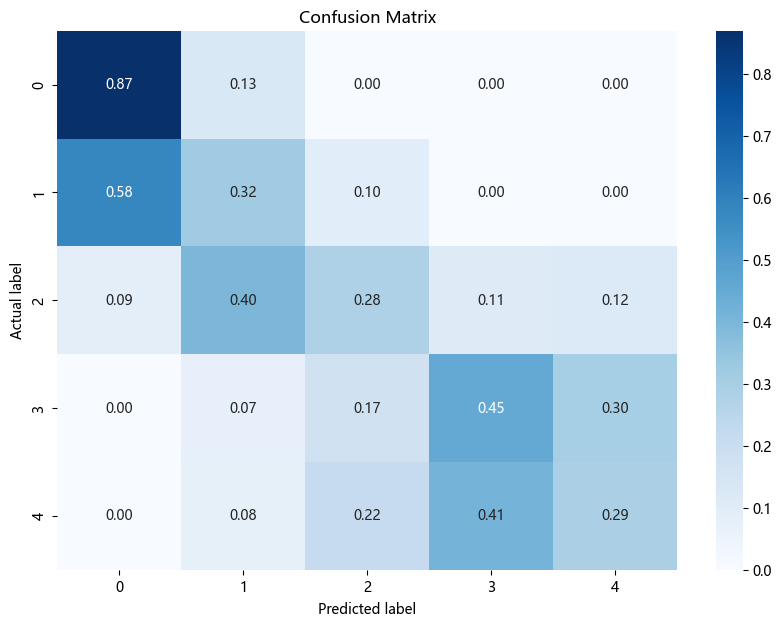

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 使用模型預測測試集
y_pred_mnb = MultinomialNB_model.predict(X_test)

# 生成混淆矩陣
cm = confusion_matrix(y_test, y_pred_mnb)

# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

### 交叉驗證(Cross-Validation)

In [33]:
from sklearn.model_selection import cross_val_score

# 定義模型
mnb_model_cv = MultinomialNB()

# 進行5-fold交叉驗證
scores = cross_val_score(mnb_model_cv, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

每一輪的準確率: [0.33220339 0.29661017 0.31239389 0.32088285 0.24787776]
平均準確率: 0.3019936116946275


### 參數調整(Parameter Tuning)

Best parameters: {'alpha': 129154.96650148826}
Best cross-validation score: 0.5598929527207851


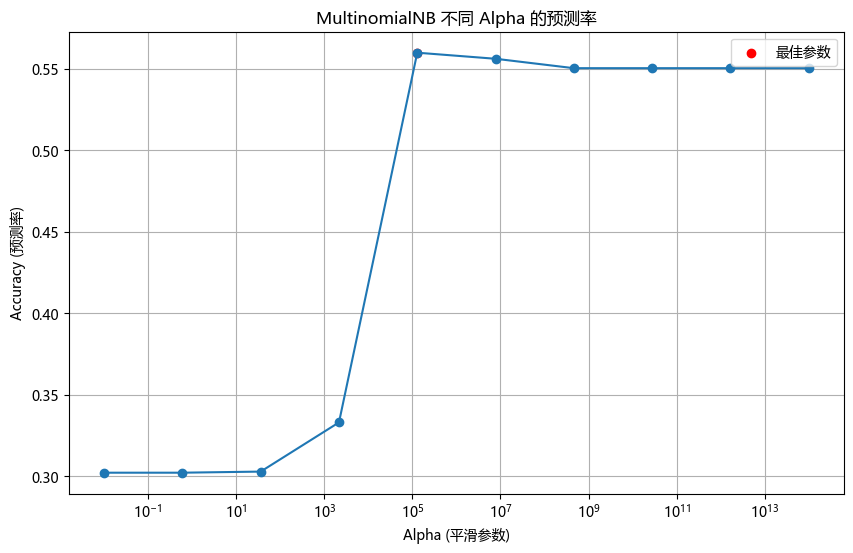

In [34]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# 定义参数范围
param_grid = {
    # 'alpha': [0.01, 0.1, 1, 10, 100, 10000]
    "alpha": np.logspace(-2, 14, num=10)
    # 平滑參數，用於解決數據集中未見過的特徵所帶來的零概率問題
}
# 建立 GridSearchCV 對象
grid_search_mnb = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    scoring="accuracy",
)

# 執行網格搜索
grid_search_mnb.fit(X_train, y_train)

# 輸出最佳參數和最佳交叉驗證分數
print("Best parameters:", grid_search_mnb.best_params_)
print("Best cross-validation score:", grid_search_mnb.best_score_)

import matplotlib.pyplot as plt

# 从grid_search_mnb获取alpha值和对应的准确率
alphas = param_grid["alpha"]
mean_scores = grid_search_mnb.cv_results_["mean_test_score"]

# 绘制alpha对应准确率的图
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, marker="o")
# 确保这里使用了正确的最佳参数和分数
plt.scatter(
    grid_search_mnb.best_params_["alpha"],
    grid_search_mnb.best_score_,
    color="red",
    marker="o",
    label="最佳参数",
)  # 标记最佳点
plt.xlabel("Alpha (平滑参数)")
plt.ylabel("Accuracy (预测率)")
plt.title("MultinomialNB 不同 Alpha 的预测率")
plt.xscale("log")  # 使用对数刻度
plt.legend()  # 显示图例
plt.grid(True)
plt.show()

## 利用最佳參數做

最佳 MultinomialNB 模型的準確度: 0.5925632911392406
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.53      0.11      0.18        72
           2       0.26      0.07      0.11       165
           3       0.00      0.00      0.00       274
           4       0.61      1.00      0.76       730

    accuracy                           0.59      1264
   macro avg       0.28      0.24      0.21      1264
weighted avg       0.42      0.59      0.46      1264



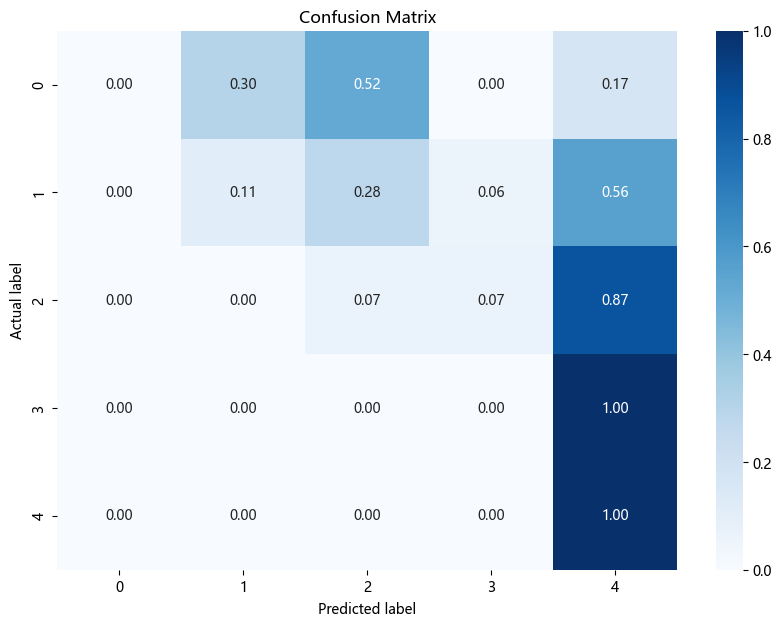

每一輪的準確率: [0.55762712 0.55762712 0.55517827 0.56027165 0.56876061]
平均準確率: 0.5598929527207851


['MultinomialNB_model_best.joblib']

In [35]:
# 忽略警告
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# 使用找到的最佳參數建立一個新的 MultinomialNB 模型
MultinomialNB_model_best = MultinomialNB(alpha=grid_search_mnb.best_params_["alpha"])

# 使用訓練數據訓練模型
MultinomialNB_model_best.fit(X_train, y_train)

# 使用測試數據進行預測
y_pred_mnb_best = MultinomialNB_model_best.predict(X_test)

# 計算準確率
accuracy_mnb_best = accuracy_score(y_test, y_pred_mnb_best)

# 生成分類報告
classification_report_mnb_best = classification_report(y_test, y_pred_mnb_best)

# 打印結果
print("最佳 MultinomialNB 模型的準確度:", accuracy_mnb_best)
print(classification_report_mnb_best)

# 繪製混淆矩陣
plot_confusion_matrix(y_test, y_pred_mnb_best)
# 進行5-fold交叉驗證
scores = cross_val_score(MultinomialNB_model_best, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

# 保存模型
dump(MultinomialNB_model_best, "MultinomialNB_model_best.joblib")

### 學習曲線(Learning Curve)

如果訓練分數和交叉驗證分數之間的差距很大，可能表示模型存在過擬合；如果兩者都很低，則可能表示欠擬合。理想情況下，隨著訓練樣本的增加，訓練分數和交叉驗證分數應該逐漸接近，且分數較高。

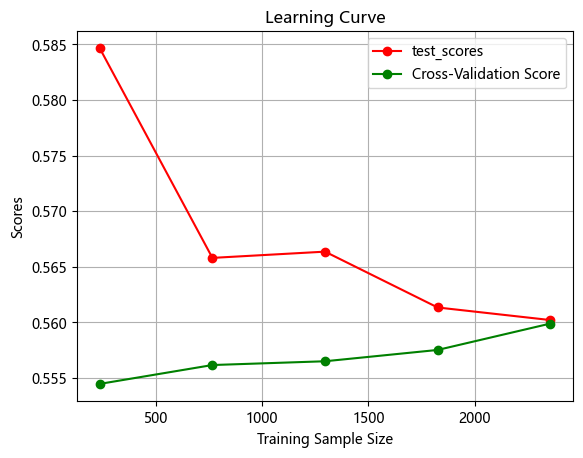

訓練和測試分數的差異百分比0.06%


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import load_digits

# 獲取學習曲線數據
train_sizes, train_scores, test_scores = learning_curve(
    MultinomialNB_model_best,  # 使用的分類器
    X_train,  # 特徵數據
    y_train,  # 目標數據
    cv=5,  # 交叉驗證分割策略
    # n_jobs=-1,      # 使用所有的 CPU 核心進行計算
    train_sizes=np.linspace(0.1, 1.0, 5),  # 定義了用於生成學習曲線的訓練集大小的比例
)


# 計算平均和標準差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Sample Size")
plt.ylabel("Scores")
plt.grid()

# # 填充訓練和測試分數之間的顏色
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# 繪製訓練和測試的分數線
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="test_scores")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()

# 計算訓練和測試分數的差異百分比
score_diff_percentage = (
    (train_scores_mean - test_scores_mean) / train_scores_mean
) * 100
print(f"訓練和測試分數的差異百分比{score_diff_percentage[-1]:.2f}%")